In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score

from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.kernels import RBF

from mfpml.models.gaussian_process import GaussianProcessRegression
from mfbml.problems.high_dimension_problems import MengCase1
# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points

# training configure
samples = [hf_samples, lf_samples]

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

In [3]:
# read the data
data = pd.read_pickle("../data_generation/data.pkl")
# # extract dataset
# samples = data["samples"]
# hf_samples = samples["hf"]
# lf_samples = samples["lf"]
# hf_responses = data["responses_lf1"]["hf"]
responses_lf1 = data["responses_lf1"]
responses_lf2 = data["responses_lf2"]
responses_lf3 = data["responses_lf3"]
# test_samples = data["test_samples"]
# test_hf_responses_noiseless = data["test_hf_responses_noiseless"]
# test_hf_responses = data["test_hf_responses"]
# test_lf1_responses = data["test_lf1_responses"]
# test_lf2_responses = data["test_lf2_responses"]
# test_lf3_responses = data["test_lf3_responses"]

In [4]:
kernel = RBF(theta=np.zeros(1), bounds=[-5, 2])

In [5]:
sf_gpr = GaussianProcessRegression(
    design_space=np.array([[0, 1]]),
    noise_prior=0.05,
    kernel=kernel,
    optimizer_restart=20,)
sf_gpr.train(X=hf_samples.numpy(), Y=hf_responses.numpy())
# save the model
with open("sf_gpr.pkl", "wb") as f:
    torch.save(sf_gpr, f)

In [6]:
sf_gpr.kernel.param

array([100.])

In [7]:
# load the model
with open("sf_gpr.pkl", "rb") as f:
    sf_model = torch.load(f)

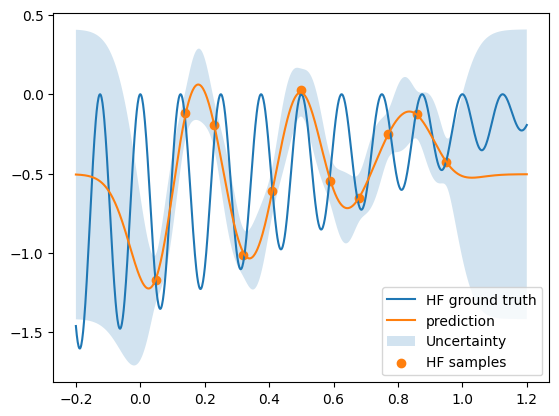

In [8]:
# get the predictions
sf_pred, sf_std = sf_model.predict(test_samples.numpy(), return_std=True)
# plot the results
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF ground truth")

ax.plot(test_samples, sf_pred, label="prediction")
ax.fill_between(test_samples.flatten(), (sf_pred - 2*sf_std).flatten(),
                (sf_pred + 2*sf_std).flatten(), alpha=0.2, label="Uncertainty")
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")

plt.legend()
plt.show()

In [9]:
# multi-fidelity model for the first low-fidelity model
# create the model
mf_model = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    kernel_bound=[-2, 2],
    noise_prior=0.05,)
# train the model
mf_model.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
               responses=[hf_responses.numpy(), responses_lf1[1].numpy(),])
# save the model
with open("mf_model_lf1.pkl", "wb") as f:
    torch.save(mf_model, f)

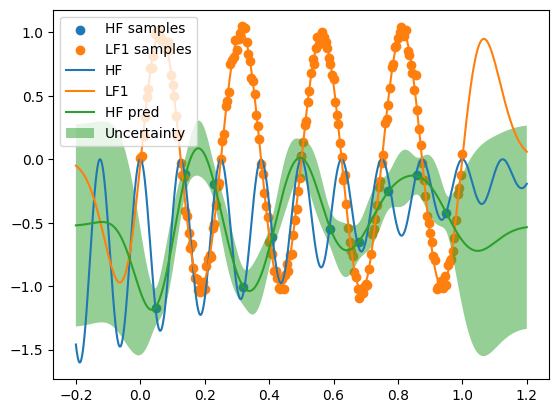

In [11]:
hf_pred_1, hf_pred_var_1 = mf_model.predict(
    test_samples.numpy(), return_std=True)
lf1_pred = mf_model.predict_lf(test_samples.numpy())
# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples,  responses_lf1[1], label="LF1 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf1_pred, label="LF1")
ax.plot(test_samples, hf_pred_1, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred_1 - 2*hf_pred_var_1).flatten(),
                (hf_pred_1 + 2*hf_pred_var_1).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

In [12]:
# multi-fidelity model for the second low-fidelity model
# create the model
mf_model = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    kernel_bound=[-2, 2],
    noise_prior=0.05,)
# train the model
mf_model.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
               responses=[hf_responses.numpy(), responses_lf2[1].numpy(),])
# save the model
with open("mf_model_lf2.pkl", "wb") as f:
    torch.save(mf_model, f)

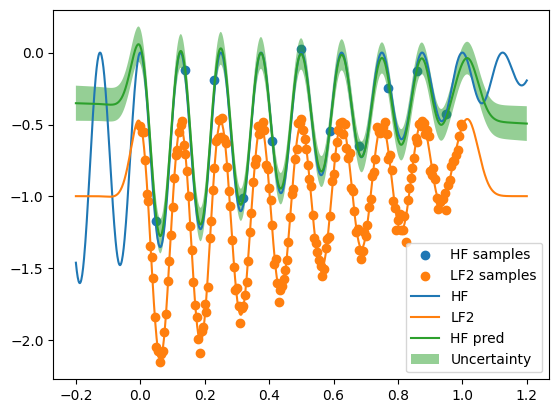

In [13]:
# plot the prediction
hf_pred_2, hf_pred_var_2 = mf_model.predict(
    test_samples.numpy(), return_std=True)
lf2_pred = mf_model.predict_lf(test_samples.numpy())
# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples,  responses_lf2[1], label="LF2 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf2_pred, label="LF2")
ax.plot(test_samples, hf_pred_2, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred_2 - 2*hf_pred_var_2).flatten(),
                (hf_pred_2 + 2*hf_pred_var_2).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

In [14]:
# multi-fidelity model for the third low-fidelity model
# create the model
mf_model = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    kernel_bound=[-2, 2],
    noise_prior=0.05,)
# train the model
mf_model.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
               responses=[hf_responses.numpy(), responses_lf3[1].numpy(),])
# save the model
with open("mf_model_lf3.pkl", "wb") as f:
    torch.save(mf_model, f)

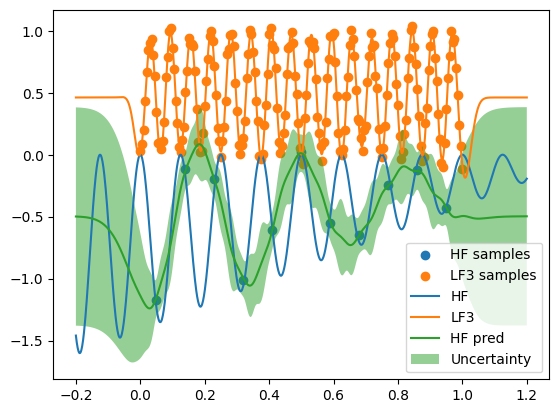

In [15]:
# plot the prediction
hf_pred_3, hf_pred_var_3 = mf_model.predict(
    test_samples.numpy(), return_std=True)
lf3_pred = mf_model.predict_lf(test_samples.numpy())
# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples,  responses_lf3[1], label="LF3 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf3_pred, label="LF3")
ax.plot(test_samples, hf_pred_3, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred_3 - 2*hf_pred_var_3).flatten(),
                (hf_pred_3 + 2*hf_pred_var_3).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

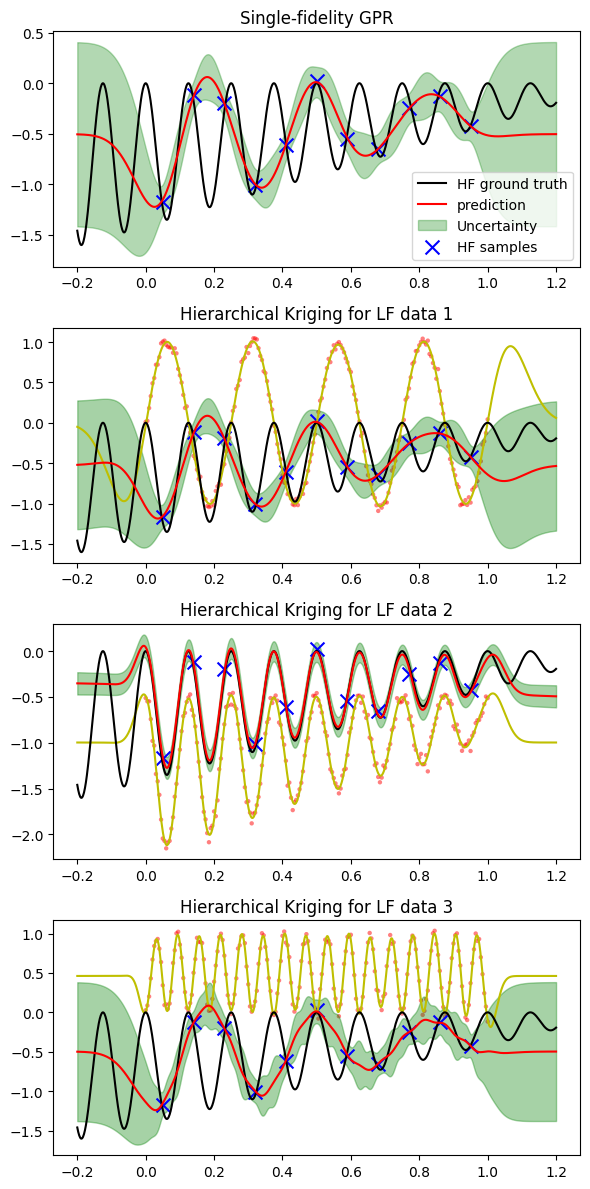

In [16]:
# plot the results into a single plot with four subplots
fig, axs = plt.subplots(4, 1, figsize=(6, 12))
# plot the high-fidelity model
axs[0].plot(test_samples, test_hf_responses_noiseless,
            color="k", label="HF ground truth")
axs[0].plot(test_samples, sf_pred, 'r', label="prediction")
axs[0].fill_between(test_samples.flatten(), (sf_pred - 2*sf_std).flatten(),
                    (sf_pred + 2*sf_std).flatten(), alpha=0.3,
                    color="g",
                    label="Uncertainty")
# plot samples
axs[0].scatter(hf_samples, hf_responses, label="HF samples",
               color="b", marker="x", s=100)
axs[0].set_title("Single-fidelity GPR")
axs[0].legend()

# plot the multi-fidelity model for the first low-fidelity model
axs[1].plot(test_samples, lf1_pred, 'y', label="prediction")
axs[1].scatter(lf_samples, responses_lf1[1], label="LF1 samples",
               color="r", marker="o", alpha=0.5, s=10, edgecolor="none",)
axs[1].plot(test_samples, test_hf_responses_noiseless,
            color="k", label="HF ground truth")
axs[1].plot(test_samples, hf_pred_1, 'r', label="HF prediction")
axs[1].fill_between(test_samples.flatten(), (hf_pred_1 - 2*hf_pred_var_1).flatten(),
                    (hf_pred_1 + 2*hf_pred_var_1).flatten(), alpha=0.35,
                    color="g",
                    label="Uncertainty")
# plot samples
axs[1].scatter(hf_samples, hf_responses, label="HF samples",
               color="b", marker="x", s=100)

axs[1].set_title("Hierarchical Kriging for LF data 1")
# axs[1].legend()

# plot the multi-fidelity model for the second low-fidelity model
axs[2].plot(test_samples, lf2_pred, 'y', label="prediction")
axs[2].scatter(lf_samples, responses_lf2[1], label="LF2 samples",
               color="r", marker="o", alpha=0.5, s=10, edgecolor="none",)
axs[2].plot(test_samples, test_hf_responses_noiseless,
            color="k", label="HF ground truth")
axs[2].plot(test_samples, hf_pred_2, 'r', label="HF prediction")
axs[2].fill_between(test_samples.flatten(), (hf_pred_2 - 2*hf_pred_var_2).flatten(),
                    (hf_pred_2 + 2*hf_pred_var_2).flatten(), alpha=0.35,
                    color="g",
                    label="Uncertainty")
# plot samples
axs[2].scatter(hf_samples, hf_responses, label="HF samples",
               color="b", marker="x", s=100)

axs[2].set_title("Hierarchical Kriging for LF data 2")
# axs[2].legend()

# plot the multi-fidelity model for the third low-fidelity model
axs[3].plot(test_samples, lf3_pred, 'y', label="prediction")
axs[3].scatter(lf_samples, responses_lf3[1], label="LF3 samples",
               color="r", marker="o", alpha=0.5, s=10, edgecolor="none",)
axs[3].plot(test_samples, test_hf_responses_noiseless,
            color="k", label="HF ground truth")
axs[3].plot(test_samples, hf_pred_3, 'r', label="HF prediction")
axs[3].fill_between(test_samples.flatten(), (hf_pred_3 - 2*hf_pred_var_3).flatten(),
                    (hf_pred_3 + 2*hf_pred_var_3).flatten(), alpha=0.35,
                    color="g",
                    label="Uncertainty")
# plot samples
axs[3].scatter(hf_samples, hf_responses, label="HF samples",
               color="b", marker="x", s=100)

axs[3].set_title("Hierarchical Kriging for LF data 3")
# axs[3].legend()

# plt.legend()
plt.tight_layout()
plt.savefig("results_hk_extrapolation.png", dpi=300)
plt.show()